In [1]:
import fitz

doc = fitz.open("example.pdf")
page = doc[0]

# 创建一个新的矩形路径
path = fitz.Path()
path.add_rect(fitz.Rect(100, 100, 200, 200))

# 访问路径的点集合和段集合
points = path.points
segments = path.segments

# 打印点和段的信息
for point in points:
    print(f"Point: {point}")
    
for segment in segments:
    print(f"Segment: {segment}")

# 计算路径的边界框
bbox = path.bound()
print(f"Bounding Box: {bbox}")

doc.close()

FileNotFoundError: no such file: 'example.pdf'

In [ ]:
import os
import sys
import fitz


def column_boxes(page, footer_margin=50, header_margin=50, no_image_text=True):
    """Determine bboxes which wrap a column."""
    paths = page.get_drawings()
    bboxes = []

    # path rectangles
    path_rects = []

    # image bboxes
    img_bboxes = []

    # bboxes of non-horizontal text
    # avoid when expanding horizontal text boxes
    vert_bboxes = []

    # compute relevant page area
    clip = +page.rect
    clip.y1 -= footer_margin  # Remove footer area
    clip.y0 += header_margin  # Remove header area

    def can_extend(temp, bb, bboxlist):
        """Determines whether rectangle 'temp' can be extended by 'bb'
        without intersecting any of the rectangles contained in 'bboxlist'.

        Items of bboxlist may be None if they have been removed.

        Returns:
            True if 'temp' has no intersections with items of 'bboxlist'.
        """
        for b in bboxlist:
            if not intersects_bboxes(temp, vert_bboxes) and (
                b == None or b == bb or (temp & b).is_empty
            ):
                continue
            return False

        return True

    def in_bbox(bb, bboxes):
        """Return 1-based number if a bbox contains bb, else return 0."""
        for i, bbox in enumerate(bboxes):
            if bb in bbox:
                return i + 1
        return 0

    def intersects_bboxes(bb, bboxes):
        """Return True if a bbox intersects bb, else return False."""
        for bbox in bboxes:
            if not (bb & bbox).is_empty:
                return True
        return False

    def extend_right(bboxes, width, path_bboxes, vert_bboxes, img_bboxes):
        """Extend a bbox to the right page border.

        Whenever there is no text to the right of a bbox, enlarge it up
        to the right page border.

        Args:
            bboxes: (list[IRect]) bboxes to check
            width: (int) page width
            path_bboxes: (list[IRect]) bboxes with a background color
            vert_bboxes: (list[IRect]) bboxes with vertical text
            img_bboxes: (list[IRect]) bboxes of images
        Returns:
            Potentially modified bboxes.
        """
        for i, bb in enumerate(bboxes):
            # do not extend text with background color
            if in_bbox(bb, path_bboxes):
                continue

            # do not extend text in images
            if in_bbox(bb, img_bboxes):
                continue

            # temp extends bb to the right page border
            temp = +bb
            temp.x1 = width

            # do not cut through colored background or images
            if intersects_bboxes(temp, path_bboxes + vert_bboxes + img_bboxes):
                continue

            # also, do not intersect other text bboxes
            check = can_extend(temp, bb, bboxes)
            if check:
                bboxes[i] = temp  # replace with enlarged bbox

        return [b for b in bboxes if b != None]

    def clean_nblocks(nblocks):
        """Do some elementary cleaning."""

        # 1. remove any duplicate blocks.
        blen = len(nblocks)
        if blen < 2:
            return nblocks
        start = blen - 1
        for i in range(start, -1, -1):
            bb1 = nblocks[i]
            bb0 = nblocks[i - 1]
            if bb0 == bb1:    # 这个为什么会出现呢？
                del nblocks[i]

        # 2. repair sequence in special cases:
        # consecutive bboxes with almost same bottom value are sorted ascending
        # by x-coordinate.
        y1 = nblocks[0].y1  # first bottom coordinate
        i0 = 0  # its index
        i1 = -1  # index of last bbox with same bottom

        # Iterate over bboxes, identifying segments with approx. same bottom value.
        # Replace every segment by its sorted version.
        for i in range(1, len(nblocks)):
            b1 = nblocks[i]
            if abs(b1.y1 - y1) > 10:  # different bottom
                if i1 > i0:  # segment length > 1? Sort it!
                    nblocks[i0 : i1 + 1] = sorted(
                        nblocks[i0 : i1 + 1], key=lambda b: b.x0
                    )
                y1 = b1.y1  # store new bottom value
                i0 = i  # store its start index
            i1 = i  # store current index
        if i1 > i0:  # segment waiting to be sorted
            nblocks[i0 : i1 + 1] = sorted(nblocks[i0 : i1 + 1], key=lambda b: b.x0)
        return nblocks
###############################################################################################
    # extract vector graphics
    for p in paths:
        path_rects.append(p["rect"].irect)
    path_bboxes = path_rects

    # sort path bboxes by ascending top, then left coordinates
    path_bboxes.sort(key=lambda b: (b.y0, b.x0))

    # bboxes of images on page, no need to sort them
    for item in page.get_images():
        img_bboxes.extend(page.get_image_rects(item[0]))

    # blocks of text on page
    blocks = page.get_text(
        "dict",
        flags=fitz.TEXTFLAGS_TEXT,
        clip=clip,
    )["blocks"]

    # Make block rectangles, ignoring non-horizontal text
    for b in blocks:
        bbox = fitz.IRect(b["bbox"])  # bbox of the block

        # ignore text written upon images
        if no_image_text and in_bbox(bbox, img_bboxes):
            continue

        # confirm first line to be horizontal
        line0 = b["lines"][0]  # get first line
        if line0["dir"] != (1, 0):  # only accept horizontal text
            vert_bboxes.append(bbox)
            continue

        srect = fitz.EMPTY_IRECT()
        for line in b["lines"]:
            lbbox = fitz.IRect(line["bbox"])
            text = "".join([s["text"].strip() for s in line["spans"]])
            if len(text) > 1:
                srect |= lbbox
        bbox = +srect

        if not bbox.is_empty:
            bboxes.append(bbox)

    # Sort text bboxes by ascending background, top, then left coordinates
    bboxes.sort(key=lambda k: (in_bbox(k, path_bboxes), k.y0, k.x0))

    # Extend bboxes to the right where possible
    bboxes = extend_right(
        bboxes, int(page.rect.width), path_bboxes, vert_bboxes, img_bboxes
    )

    # immediately return of no text found
    if bboxes == []:
        return []

    # --------------------------------------------------------------------
    # Join bboxes to establish some column structure
    # --------------------------------------------------------------------
    # the final block bboxes on page
    nblocks = [bboxes[0]]  # pre-fill with first bbox
    bboxes = bboxes[1:]  # remaining old bboxes

    for i, bb in enumerate(bboxes):  # iterate old bboxes
        check = False  # indicates unwanted joins

        # check if bb can extend one of the new blocks
        for j in range(len(nblocks)):
            nbb = nblocks[j]  # a new block

            # never join across columns
            if bb == None or nbb.x1 < bb.x0 or bb.x1 < nbb.x0:
                continue

            # never join across different background colors
            if in_bbox(nbb, path_bboxes) != in_bbox(bb, path_bboxes):
                continue

            temp = bb | nbb  # temporary extension of new block
            check = can_extend(temp, nbb, nblocks)
            if check == True:
                break

        if not check:  # bb cannot be used to extend any of the new bboxes
            nblocks.append(bb)  # so add it to the list
            j = len(nblocks) - 1  # index of it
            temp = nblocks[j]  # new bbox added

        # check if some remaining bbox is contained in temp
        check = can_extend(temp, bb, bboxes)
        if check == False:
            nblocks.append(bb)
        else:
            nblocks[j] = temp
        bboxes[i] = None

    # do some elementary cleaning
    nblocks = clean_nblocks(nblocks)

    # return identified text bboxes
    return nblocks


if __name__ == "__main__":
    # get the file name
    filename = "ctw_findpeaks.pdf"
    footer_margin = 50

    # check if footer margin is given
    # if len(sys.argv) > 2:
    #     footer_margin = int(sys.argv[2])
    # else:  # use default vaue
    #     footer_margin = 50

    # check if header margin is given
    if len(sys.argv) > 3:
        header_margin = int(sys.argv[3])
    else:  # use default vaue
        header_margin = 50

    # open document
    doc = fitz.open(filename)

    # iterate over the pages
    for page in doc:
        # remove any geometry issues
        page.wrap_contents()

        # get the text bboxes
        bboxes = column_boxes(page, footer_margin=footer_margin, header_margin=header_margin)

        # prepare a canvas to draw rectangles and text
        shape = page.new_shape()

        # iterate over the bboxes
        for i, rect in enumerate(bboxes):
            shape.draw_rect(rect)  # draw a border

            # write sequence number
            shape.insert_text(rect.tl + (5, 15), str(i), color=fitz.pdfcolor["red"])

        # finish drawing / text with color red
        shape.finish(color=fitz.pdfcolor["red"])
        shape.commit()  # store to the page

    # save document with text bboxes
    doc.ez_save(filename.replace(".pdf", "-bbox.pdf"))

In [78]:
def show_image(item, title=""):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: any PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and using matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    import numpy as np
    import matplotlib.pyplot as plt

    # %matplotlib inline
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set title of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

## path

In [6]:
import os
import sys
import fitz


filename = "ctw_findpeaks.pdf"

doc = fitz.open(filename)
page = doc[1]

# 展示出path
path_bbox = []
paths = page.get_drawings()
for p in paths:
    path_bbox.append(p["rect"].irect)
    

In [7]:
path_bbox

[IRect(433, 395, 445, 396),
 IRect(455, 395, 471, 396),
 IRect(56, 51, 559, 52),
 IRect(56, 732, 559, 734)]

In [13]:
# 保存到一个临时的pdf里
new_doc = fitz.open()
new_doc.insert_pdf(doc, from_page=1, to_page=1)
page = new_doc[0]

shape = page.new_shape()
# iterate over the bboxes
for i, rect in enumerate(path_bbox):
    shape.draw_rect(rect)  # draw a border
    # write sequence number
    #shape.insert_text(rect.tl + (5, 15), str(i), color=fitz.pdfcolor["red"])

    # finish drawing / text with color red
    shape.finish(color=fitz.pdfcolor["red"])
    shape.commit()  # store to the page

new_doc.save(f'temp/path-bbox-{filename}.pdf')


## Text

In [17]:
new_doc = fitz.open()
new_doc.insert_pdf(doc, from_page=1, to_page=1)
page = new_doc[0]

blocks = page.get_text(
        "dict",
        flags=fitz.TEXTFLAGS_TEXT,
        #clip=clip,
    )["blocks"]

len(blocks)

14

In [40]:
import json
print(json.dumps(blocks[7], indent=4))

{
    "number": 7,
    "type": 0,
    "bbox": [
        353.8204040527344,
        379.9989013671875,
        470.34088134765625,
        420.70989990234375
    ],
    "lines": [
        {
            "spans": [
                {
                    "size": 5.57889986038208,
                    "flags": 4,
                    "font": "AdvP696A",
                    "color": 2236191,
                    "ascender": 0.75,
                    "descender": -0.25,
                    "text": "R",
                    "origin": [
                        353.8204040527344,
                        409.1528015136719
                    ],
                    "bbox": [
                        353.8204040527344,
                        404.9686279296875,
                        357.245849609375,
                        410.5475158691406
                    ]
                }
            ],
            "wmode": 0,
            "dir": [
                1.0,
                0.0
            ],
       

In [20]:
text_blocks = []
for bbox in blocks:
    text_blocks.append(bbox['bbox'])

len(text_blocks)

14

In [36]:
from fitz import Point

shape = page.new_shape()
# iterate over the bboxes
for i, rect in enumerate(text_blocks):
    shape.draw_rect(rect)  # draw a border
    shape.insert_text(Point(rect[0], rect[1])+(5, 15), str(i), color=fitz.pdfcolor["blue"])
    shape.finish(color=fitz.pdfcolor["red"])
    shape.commit()  # store to the page

new_doc.save(f'temp/text-bbox-{filename}.pdf')

In [61]:
## 文字，水平与非水平分开
h_bbox = []
v_bbox = []
img_bboxes = []

for bbox in blocks:
    line_dir = bbox['lines'][0]['dir']
    if line_dir!=(1.0, 0.0):
        v_bbox.append(bbox['bbox'])
    else:
        h_bbox.append(bbox['bbox'])
        
for item in page.get_images():
    img_bboxes.extend(page.get_image_rects(item[0]))

img_bboxes

[Rect(344.6328125, 69.83708190917969, 529.5819091796875, 230.62127685546875)]

In [63]:
new_doc = fitz.open()
new_doc.insert_pdf(doc, from_page=1, to_page=1)
page = new_doc[0]

shape = page.new_shape()
# iterate over the bboxes
for i, rect in enumerate(h_bbox):
    shape.draw_rect(rect)  # draw a border
    shape.insert_text(Point(rect[0], rect[1])+(5, 15), str(i), color=fitz.pdfcolor["blue"])
    shape.finish(color=fitz.pdfcolor["red"])
    shape.commit()  # store to the page

for i, rect in enumerate(v_bbox):
    shape.draw_rect(rect)  # draw a border
    shape.insert_text(Point(rect[0], rect[1])+(5, 15), str(i), color=fitz.pdfcolor["red"])
    shape.finish(color=fitz.pdfcolor["blue"])
    shape.commit()  # store to the page

for i, rect in enumerate(img_bboxes):
    shape.draw_rect(rect)  # draw a border
    shape.insert_text(Point(rect[0], rect[1])+(5, 15), str(i), color=fitz.pdfcolor["red"])
    shape.finish(color=fitz.pdfcolor["yellow"])
    shape.commit()  # store to the page

new_doc.save(f'temp/text-diff-bbox-{filename}.pdf')

## 表格

In [75]:
filename = "论文-图、表、公式.pdf"

doc = fitz.open(filename)
page_num = 7

page = doc[page_num]

blocks = page.get_text(
        "dict",
        flags=fitz.TEXTFLAGS_TEXT,
        #clip=clip,
    )["blocks"]

text_blocks = []
for bbox in blocks:
    text_blocks.append(bbox['bbox'])
    
h_bbox = []
v_bbox = []
img_bboxes = []

for bbox in blocks:
    line_dir = bbox['lines'][0]['dir']
    if line_dir!=(1.0, 0.0):
        v_bbox.append(bbox['bbox'])
    else:
        h_bbox.append(bbox['bbox'])
        
for item in page.get_images():
    img_bboxes.extend(page.get_image_rects(item[0]))

len(h_bbox)

13

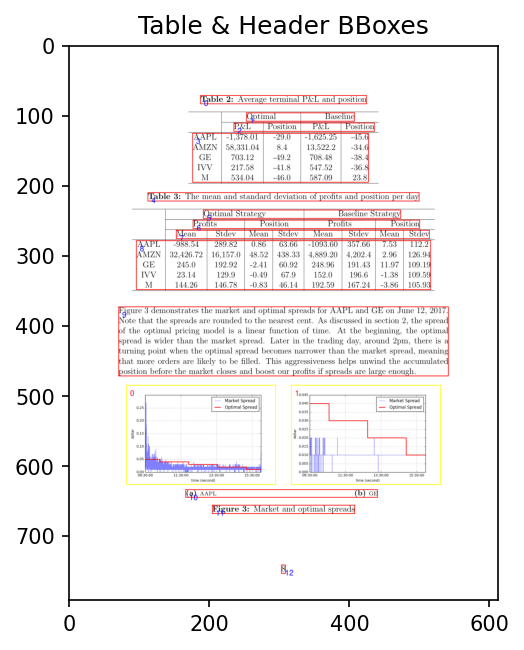

In [79]:
new_doc = fitz.open()

new_doc.insert_pdf(doc, from_page=page_num, to_page=page_num)
page = new_doc[0]

shape = page.new_shape()
# iterate over the bboxes
for i, rect in enumerate(h_bbox):
    shape.draw_rect(rect)  # draw a border
    shape.insert_text(Point(rect[0], rect[1])+(5, 15), str(i), color=fitz.pdfcolor["blue"])
    shape.finish(color=fitz.pdfcolor["red"])
    shape.commit()  # store to the page

for i, rect in enumerate(v_bbox):
    shape.draw_rect(rect)  # draw a border
    shape.insert_text(Point(rect[0], rect[1])+(5, 15), str(i), color=fitz.pdfcolor["red"])
    shape.finish(color=fitz.pdfcolor["blue"])
    shape.commit()  # store to the page

for i, rect in enumerate(img_bboxes):
    shape.draw_rect(rect)  # draw a border
    shape.insert_text(Point(rect[0], rect[1])+(5, 15), str(i), color=fitz.pdfcolor["red"])
    shape.finish(color=fitz.pdfcolor["yellow"])
    shape.commit()  # store to the page

#new_doc.save(f'temp/text-diff-bbox-{filename}-{page_num}.pdf')
show_image(page, f"Table & Header BBoxes")

Table 0 column names: ['Optimal', None, None], external: False
Table 1 column names: ['Optimal Strategy', None, None, None, None, None, None], external: False


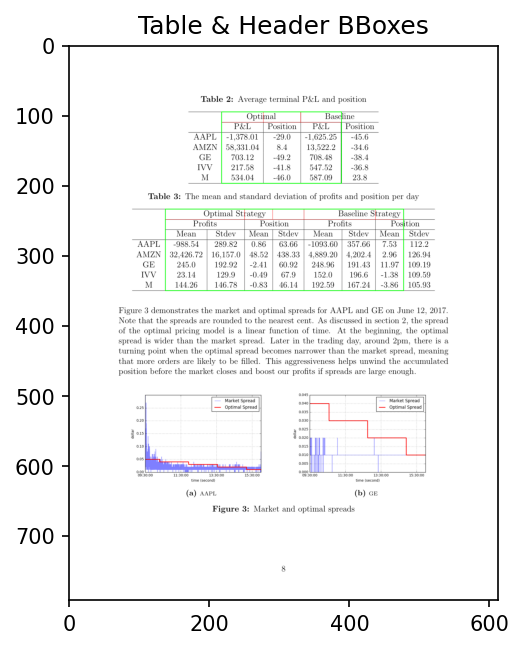

In [80]:
doc = fitz.open(filename)
page = doc[page_num]

tabs = page.find_tables()  # detect the tables
for i,tab in enumerate(tabs):  # iterate over all tables
    for cell in tab.header.cells:
        page.draw_rect(cell,color=fitz.pdfcolor["red"],width=0.3)
    page.draw_rect(tab.bbox,color=fitz.pdfcolor["green"])
    print(f"Table {i} column names: {tab.header.names}, external: {tab.header.external}")

path_bbox = []
paths = page.get_drawings()
for p in paths:
    path_bbox.append(p["rect"].irect)


show_image(page, f"Table & Header BBoxes")

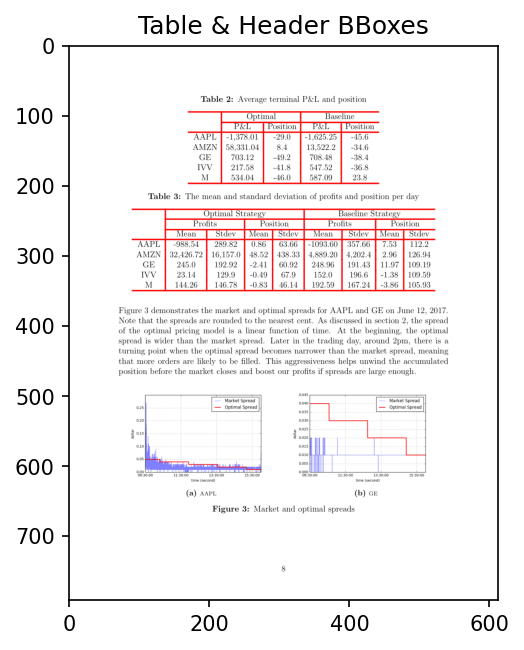

In [81]:
doc = fitz.open(filename)
page = doc[page_num]

# tabs = page.find_tables()  # detect the tables
# for i,tab in enumerate(tabs):  # iterate over all tables
#     for cell in tab.header.cells:
#         page.draw_rect(cell,color=fitz.pdfcolor["red"],width=0.3)
#     page.draw_rect(tab.bbox,color=fitz.pdfcolor["green"])
#     print(f"Table {i} column names: {tab.header.names}, external: {tab.header.external}")

path_bbox = []
paths = page.get_drawings()
for p in paths:
    path_bbox.append(p["rect"].irect)

shape = page.new_shape()
# iterate over the bboxes
for i, rect in enumerate(path_bbox):
    shape.draw_rect(rect)  # draw a border
    #shape.insert_text(Point(rect[0], rect[1])+(5, 15), str(i), color=fitz.pdfcolor["blue"])
    shape.finish(color=fitz.pdfcolor["red"])
    shape.commit()  # store to the page
    
show_image(page, f"Table & Header BBoxes")

## 公式内的文字是什么

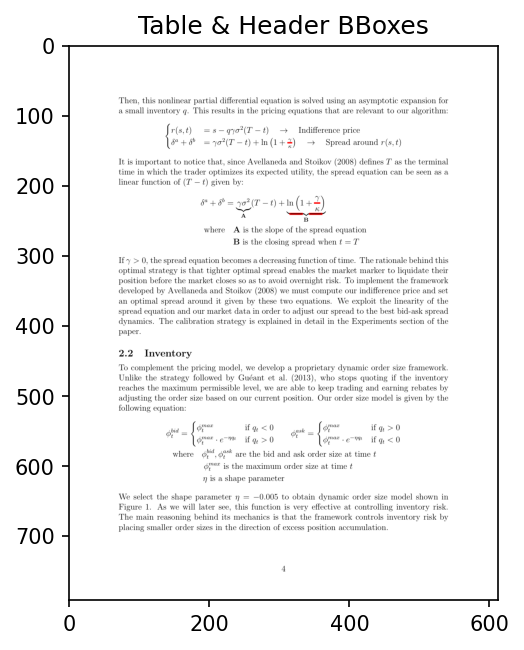

In [83]:
filename = "论文-图、表、公式.pdf"
page_num = 3
doc = fitz.open(filename)
page = doc[page_num]

path_bbox = []
paths = page.get_drawings()
for p in paths:
    path_bbox.append(p["rect"].irect)

shape = page.new_shape()
# iterate over the bboxes
for i, rect in enumerate(path_bbox):
    shape.draw_rect(rect)  # draw a border
    #shape.insert_text(Point(rect[0], rect[1])+(5, 15), str(i), color=fitz.pdfcolor["blue"])
    shape.finish(color=fitz.pdfcolor["red"])
    shape.commit()  # store to the page
    
show_image(page, f"Table & Header BBoxes")